In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]


class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, battery_level=100):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.battery_level = battery_level

    def __lt__(self, other):
        return self.path_cost < other.path_cost

In [ ]:
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.initial = start
        self.goal = goal

    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    def is_goal(self, state):
        return state == self.goal

In [93]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.num_recharges_ucs = 0
        self.num_recharges_astar = 0
        self.recharged_ucs = False
        self.recharged_astar = False

    def uniform_cost_search(self):
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        battery_level = {self.env.initial: 100}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                new_battery = battery_level[current_node.state] - 10
                if new_battery <= 0:
                    if not self.recharged_ucs:
                        self.num_recharges_ucs += 1
                        self.recharged_ucs = True
                    self.recharge_battery(new_state, battery_level)
                    new_battery = 100
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost, new_battery), new_cost)
                    came_from[new_state] = current_node.state
                    battery_level[new_state] = new_battery

        return []

    def a_star_search(self):
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        battery_level = {self.env.initial: 100}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                new_battery = battery_level[current_node.state] - 10
                if new_battery <= 0:
                    if not self.recharged_astar:
                        self.num_recharges_astar += 1
                        self.recharged_astar = True
                    self.recharge_battery(new_state, battery_level)
                    new_battery = 100
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)
                    frontier.put(Node(new_state, current_node, action, new_cost, new_battery), priority)
                    came_from[new_state] = current_node.state
                    battery_level[new_state] = new_battery

        return []

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path

    def recharge_battery(self, state, battery_level):
        battery_level[state] = 100


In [ ]:
def heuristic(state, goal):
    x1, y1 = state
    x2, y2 = goal
    return abs(x2 - x1) + abs(y2 - y1)

In [ ]:
def visualize_grid_and_path(grid, path, battery_levels):
    grid_array = np.array(grid)
    fig, ax = plt.subplots()

    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.
    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

    # Print battery level alongside each step
    for i, (x, y) in enumerate(path):
        battery_level = battery_levels[i]
        ax.text(y, x, f'{battery_level}%', color='black', ha='center', va='center')

    plt.show()


In [ ]:
grid = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
]

Solution Path (UCS): [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 9)]
Number of times battery recharged (UCS): 1


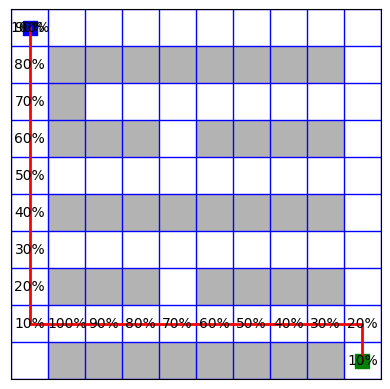

Solution Path (A*): [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]
Number of times battery recharged (A*): 1


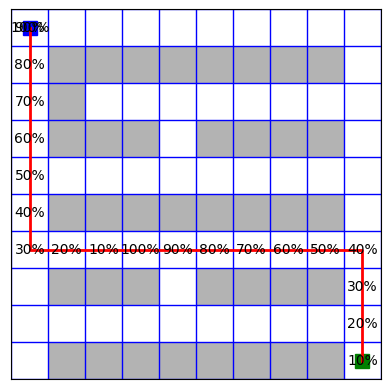

In [94]:
start = (0, 0)
goal = (9, 9)

environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with the Uniform Cost Search (UCS) algorithm
solution_path_ucs = agent.uniform_cost_search()
print("Solution Path (UCS):", solution_path_ucs)
print("Number of times battery recharged (UCS):", agent.num_recharges_ucs)

# Calculate battery levels for UCS
battery_levels_ucs = [100]
for i in range(1, len(solution_path_ucs)):
    battery_levels_ucs.append(battery_levels_ucs[-1] - 10)
    if battery_levels_ucs[-1] <= 0:
        battery_levels_ucs[-1] = 100

# Visualize the solution for UCS
visualize_grid_and_path(grid, solution_path_ucs, battery_levels_ucs)

# Solve the problem with the A* algorithm
solution_path_astar = agent.a_star_search()
print("Solution Path (A*):", solution_path_astar)
print("Number of times battery recharged (A*):", agent.num_recharges_astar)
# Calculate battery levels for A*
battery_levels_astar = [100]
for i in range(1, len(solution_path_astar)):
    battery_levels_astar.append(battery_levels_astar[-1] - 10)
    if battery_levels_astar[-1] <= 0:
        battery_levels_astar[-1] = 100

# Visualize the solution for A*
visualize_grid_and_path(grid, solution_path_astar, battery_levels_astar)